In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import pyspark
from pyspark.sql import SparkSession
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyspark.ml.stat import Correlation
import warnings
warnings.filterwarnings('ignore')

In [2]:
spark = SparkSession.builder.appName('red-wine-classification').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/10 23:09:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/10 23:09:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## 1. Load data

In [3]:
df = spark.read.csv('Datasets/winequality-red.csv', inferSchema=True, header=True)
df.show()

+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|               null|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|               null|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|              0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0

## 2. Explore data

In [4]:
# Get the data schema.
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [5]:
df.toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1597.0,0.087467,0.047093,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


### 2.1 Feature Correlation

<AxesSubplot:>

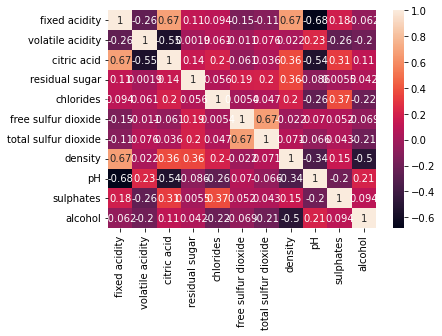

In [6]:
# sns.set(rc={'figure.figsize':(12,10)})
pearsonCorr = df.toPandas().iloc[:, : 11].corr()
sns.heatmap(pearsonCorr, annot=True)

### 2.2 Count Missing values

In [7]:
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count
print("Missing values:")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

Missing values:
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density| pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|            0|               0|          0|             0|        2|                  0|                   0|      0|  0|        0|      0|      0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+



### 2.3 Print Boxplot for each feature

<AxesSubplot:xlabel='fixed acidity'>

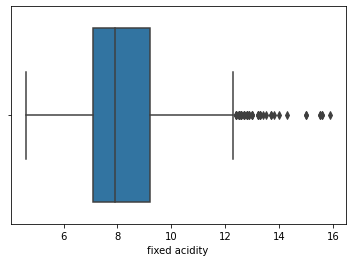

In [8]:
sns.boxplot(x=df.toPandas()['fixed acidity'])

## 3. Data Preparation

### 3.1 Detect and remove outliers

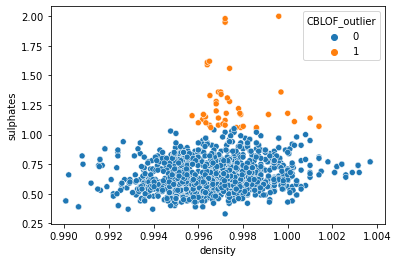

In [9]:
# Detect outliers by using CBLOF algorithmn
dfp = df.toPandas()
cblof_clf = CBLOF(contamination=0.03,check_estimator=False, random_state=1)
cblof_clf.fit(dfp[['density', 'sulphates']])
dfp['CBLOF_outlier'] = cblof_clf.labels_
# Visulise outliers
sns.scatterplot(data=dfp, x='density', y='sulphates', hue='CBLOF_outlier')
# Remove outliers
dfp = dfp[dfp['CBLOF_outlier']==0]
dfp = dfp.drop(['CBLOF_outlier'], axis=1)
df=spark.createDataFrame(dfp) 

In [10]:
dfp.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,NaN,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,NaN,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [11]:
df.toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1551.0,8.309478,1.752026,4.60000,7.10000,7.9000,9.200000,15.90000
volatile acidity,1551.0,0.528524,0.179451,0.12000,0.39000,0.5200,0.640000,1.58000
citric acid,1551.0,0.265622,0.192643,0.00000,0.09000,0.2500,0.420000,0.79000
residual sugar,1551.0,2.545293,1.418683,0.90000,1.90000,2.2000,2.600000,15.50000
chlorides,1549.0,0.083163,0.028310,0.01200,0.07000,0.0790,0.089000,0.38700
free sulfur dioxide,1551.0,15.867182,10.512992,1.00000,7.00000,13.0000,21.000000,72.00000
total sulfur dioxide,1551.0,45.881367,32.463753,6.00000,22.00000,37.0000,61.000000,289.00000
density,1551.0,0.996723,0.001897,0.99007,0.99557,0.9967,0.997825,1.00369
pH,1551.0,3.317485,0.150423,2.86000,3.21500,3.3100,3.400000,4.01000
sulphates,1551.0,0.639194,0.124946,0.33000,0.55000,0.6200,0.720000,1.05000


### 3.2 Impute missing values

In [12]:
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCol="chlorides", outputCol="chlorides")
print("Missing value counts before imputation:")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
df = imputer.fit(df).transform(df)
print("Missing value counts after imputation:")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

Missing value counts before imputation:
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density| pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|            0|               0|          0|             0|        2|                  0|                   0|      0|  0|        0|      0|      0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+

Missing value counts after imputation:
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|fixed acidity|volatile ac

### 3.3 Feature derivative

In [13]:
from sklearn.preprocessing import PolynomialFeatures
df_feature = df.toPandas().drop(['quality'], axis=1)
X_before = df_feature.to_numpy()
print("The shape of feature matrix before feature derivative: ", X_before.shape)
poly = PolynomialFeatures(interaction_only=True)
X_after = poly.fit_transform(X_before)
print("The shape of feature matrix after feature derivative: ", X_after.shape)

The shape of feature matrix before feature derivative:  (1551, 11)
The shape of feature matrix after feature derivative:  (1551, 67)


### 3.4 SMOTE oversampling

In [14]:
from imblearn.over_sampling import SMOTE
col_names = df.toPandas().columns
print("data instances before SMOTE sampling: ", len(df.toPandas()))
df_y = df.toPandas()[['quality']]
df_X = df.toPandas().drop(['quality'], axis=1)
X = df_X.to_numpy()
y = df_y.to_numpy()
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
arr = np.concatenate([X_resampled, y_resampled.reshape(-1, 1)],axis=1)
sampled_df = pd.DataFrame(arr, columns=col_names)
print("data instances after SMOTE sampling: ", len(sampled_df))
df=spark.createDataFrame(sampled_df) 

data instances before SMOTE sampling:  1551
data instances after SMOTE sampling:  3930


### 3.5 Format the data after integration

In [15]:
df_red_wine = spark.read.csv('Datasets/winequality-red.csv', inferSchema=True, header=True)
df_white_wine = spark.read.csv('Datasets/winequality-white.csv', inferSchema=True, header=True)
dfp = df_red_wine.toPandas().append(df_white_wine.toPandas())
red_wine_count = len(df_red_wine.toPandas())
white_wine_count = len(df_white_wine.toPandas())
dfp['is_red_wine'] = [1] * red_wine_count + [0] * white_wine_count
df_combines = spark.createDataFrame(dfp)
dfp.sample(n=5, random_state=1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red_wine
110,7.8,0.56,0.19,1.8,0.104,12.0,47.0,0.99640,3.19,0.93,9.5,5,1
1202,8.6,0.42,0.39,1.8,0.068,6.0,12.0,0.99516,3.35,0.69,11.7,8,0
892,10.1,0.45,0.23,1.9,0.082,10.0,18.0,0.99774,3.22,0.65,9.3,6,0
258,7.7,0.41,0.76,1.8,0.611,8.0,45.0,0.99680,3.06,1.26,9.4,5,0
560,12.7,0.60,0.49,2.8,0.075,5.0,19.0,0.99940,3.14,0.57,11.4,5,1


## 4. Data Transformation

### 4.1 Feature selection

In [16]:
from pyspark.ml.feature import VectorAssembler
featureCols = list(df.toPandas().columns[:-1])
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

In [17]:
df = assembler.transform(df)
df.show()

+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|            features|
+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+
|          7.4|             0.7|        0.0|           1.9|0.08316333118140737|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    5.0|[7.4,0.7,0.0,1.9,...|
|          7.8|            0.88|        0.0|           2.6|0.08316333118140737|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|    5.0|[7.8,0.88,0.0,2.6...|
|          7.8|            0.76|       0.04|           2.3|              0.092|               1

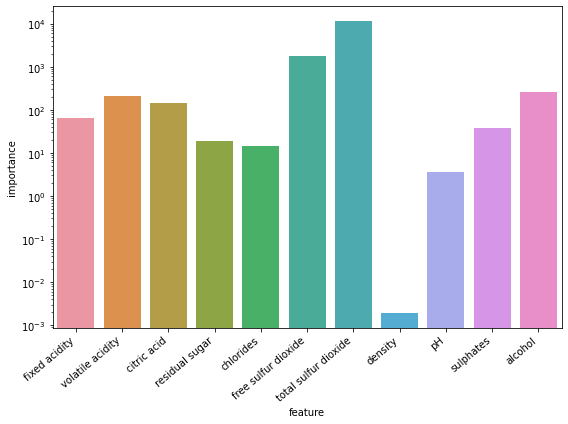

In [18]:
# visulisation
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
df_y = df[['quality']]
df_X = df.drop('quality').drop('features')
X = df_X.toPandas().to_numpy()
y = df_y.toPandas().to_numpy()
sk = SelectKBest(chi2)
X_new = sk.fit_transform(X, y)
scores = list(sk.scores_)
data = pd.DataFrame({'feature':  df_X.columns, 'importance': scores})
plt.figure(figsize=(8,6))
g = sns.barplot(data=data, x="feature", y="importance")
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")
g.set_yscale("log")
plt.tight_layout()
plt.show()

In [19]:
from pyspark.ml.feature import ChiSqSelector
selector=ChiSqSelector(percentile=0.9, featuresCol="features", outputCol="selectedFeatures", labelCol= "quality")
model=selector.fit(df)
df = model.transform(df)
df.show()

+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|            features|    selectedFeatures|
+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+
|          7.4|             0.7|        0.0|           1.9|0.08316333118140737|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    5.0|[7.4,0.7,0.0,1.9,...|[7.4,0.7,0.0,1.9,...|
|          7.8|            0.88|        0.0|           2.6|0.08316333118140737|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|    5.0|[7.8,0.88,0.0,2.6...|[7.8,0.88,0.

### 4.2 Feature transformation

In [20]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="selectedFeatures", outputCol="transformedFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(df)
# Normalize each feature to have unit standard deviation.
df = scalerModel.transform(df)
df.show()

+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+--------------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|            features|    selectedFeatures| transformedFeatures|
+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+--------------------+
|          7.4|             0.7|        0.0|           1.9|0.08316333118140737|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    5.0|[7.4,0.7,0.0,1.9,...|[7.4,0.7,0.0,1.9,...|[4.45879142390061...|
|          7.8|            0.88|        0.0|           2.6|0.08316333118140737|               25.0|         

### 4.3 Reclassification

In [21]:
from itertools import chain
from pyspark.sql.functions import create_map, lit
simple_dict = {3.0:'bad', 4.0:'bad', 5.0:'average', 6.0:'average', 7.0:'good', 8.0:'good'}
mapping_expr = create_map([lit(x) for x in chain(*simple_dict.items())])
df = df.withColumn('quality-reclassified', mapping_expr[df['quality']])
df.show()

+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+--------------------+--------------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|            features|    selectedFeatures| transformedFeatures|quality-reclassified|
+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+--------------------+--------------------+
|          7.4|             0.7|        0.0|           1.9|0.08316333118140737|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    5.0|[7.4,0.7,0.0,1.9,...|[7.4,0.7,0.0,1.9,...|[4.45879142390061...|             average|
|          7.8|         

### 4.4 Encode label

In [22]:
from pyspark.ml.feature import StringIndexer
label_stringIdx = StringIndexer(inputCol = 'quality-reclassified', outputCol = 'labelIndex')
df = label_stringIdx.fit(df).transform(df)
df.show()

+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+--------------------+--------------------+----------+
|fixed acidity|volatile acidity|citric acid|residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|            features|    selectedFeatures| transformedFeatures|quality-reclassified|labelIndex|
+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+--------------------+--------------------+--------------------+--------------------+----------+
|          7.4|             0.7|        0.0|           1.9|0.08316333118140737|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    5.0|[7.4,0.7,0.0,1.9,...|[7.4,0.7,0.0,1.9,...|[4.45879142390061...|             

## 5. Modelling and Evaludation

### 5.1 Split dataset 

In [23]:
train, test = df.randomSplit([0.7, 0.3], seed = 2022)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 2746
Test Dataset Count: 1184


### 5.2 Decision Tree

In [24]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'transformedFeatures', labelCol = 'labelIndex')
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

In [25]:
predictions.select('labelIndex', 'prediction', 'probability').show(truncate=False)

+----------+----------+-------------------------------------------------------------+
|labelIndex|prediction|probability                                                  |
+----------+----------+-------------------------------------------------------------+
|0.0       |0.0       |[0.9395973154362416,0.013422818791946308,0.04697986577181208]|
|2.0       |2.0       |[0.05989110707803993,0.0,0.9401088929219601]                 |
|0.0       |1.0       |[0.44642857142857145,0.5535714285714286,0.0]                 |
|2.0       |2.0       |[0.05989110707803993,0.0,0.9401088929219601]                 |
|0.0       |2.0       |[0.05989110707803993,0.0,0.9401088929219601]                 |
|2.0       |0.0       |[0.9395973154362416,0.013422818791946308,0.04697986577181208]|
|2.0       |2.0       |[0.05989110707803993,0.0,0.9401088929219601]                 |
|0.0       |0.0       |[0.9395973154362416,0.013422818791946308,0.04697986577181208]|
|2.0       |0.0       |[0.49032258064516127,0.44516129

In [26]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.7796017995188732
Test Error = 0.2203982004811268


In [27]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

preds_and_labels = predictions.select(['prediction','labelIndex']).withColumn('labelIndex', F.col('labelIndex').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','labelIndex'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

[[280.  51.  75.]
 [ 73. 307.   7.]
 [ 55.   0. 336.]]


In [28]:
print("Model information: ", dtModel)

Model information:  DecisionTreeClassificationModel: uid=DecisionTreeClassifier_9af557e55f6e, depth=5, numNodes=51, numClasses=3, numFeatures=11


In [29]:
print(dtModel.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_9af557e55f6e, depth=5, numNodes=51, numClasses=3, numFeatures=11
  If (feature 9 <= 5.096050556720404)
   If (feature 1 <= 2.794345113410528)
    If (feature 5 <= 1.647539057038243)
     If (feature 1 <= 2.3513379095478983)
      If (feature 10 <= 9.456394012977793)
       Predict: 0.0
      Else (feature 10 > 9.456394012977793)
       Predict: 2.0
     Else (feature 1 > 2.3513379095478983)
      If (feature 2 <= 1.625296571973692)
       Predict: 0.0
      Else (feature 2 > 1.625296571973692)
       Predict: 1.0
    Else (feature 5 > 1.647539057038243)
     If (feature 6 <= 1.9651128406894842)
      If (feature 6 <= 1.5104928133733768)
       Predict: 0.0
      Else (feature 6 > 1.5104928133733768)
       Predict: 1.0
     Else (feature 6 > 1.9651128406894842)
      Predict: 0.0
   Else (feature 1 > 2.794345113410528)
    If (feature 8 <= 21.202658296769958)
     If (feature 4 <= 3.3314933947479886)
      Predict: 0.0
     El

### 5.3 Random Forest

In [30]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'transformedFeatures', labelCol = 'labelIndex')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [31]:
predictions.select('labelIndex', 'prediction', 'probability').show(truncate=False)

+----------+----------+-------------------------------------------------------------+
|labelIndex|prediction|probability                                                  |
+----------+----------+-------------------------------------------------------------+
|0.0       |0.0       |[0.5377980240834146,0.12129698579536893,0.34090499012121644] |
|2.0       |2.0       |[0.16769041065024537,0.001448441814710145,0.8308611475350444]|
|0.0       |0.0       |[0.557641882077904,0.16980479668327833,0.2725533212388177]   |
|2.0       |2.0       |[0.24629620324175255,0.02747220307240034,0.7262315936858471] |
|0.0       |2.0       |[0.31203413076628944,4.990747261025499E-4,0.6874667945076081]|
|2.0       |0.0       |[0.595343507569367,0.12484001640890699,0.279816476021726]    |
|2.0       |2.0       |[0.23773362654104258,0.024814150217892846,0.7374522232410645]|
|0.0       |0.0       |[0.6856476384986709,0.2529427157277043,0.0614096457736249]   |
|2.0       |2.0       |[0.306064851664809,0.2587150939

In [32]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.8241881455632176
Test Error = 0.17581185443678238


In [33]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

preds_and_labels = predictions.select(['prediction','labelIndex']).withColumn('labelIndex', F.col('labelIndex').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','labelIndex'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

[[296.  49.  61.]
 [ 58. 327.   2.]
 [ 36.   1. 354.]]


In [34]:
print("Model information: ", rfModel)

Model information:  RandomForestClassificationModel: uid=RandomForestClassifier_d498a8156794, numTrees=20, numClasses=3, numFeatures=11


In [40]:
#print(rfModel.toDebugString)

### 5.4 Cross Validation

In [43]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestClassifier(labelCol="labelIndex", featuresCol="transformedFeatures")

# Evaluate model
rfevaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="labelIndex", metricName="accuracy")

# Create ParamGrid for Cross Validation
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 5, 10])
               .addGrid(rf.maxBins, [5, 10, 20])
               .addGrid(rf.numTrees, [5, 20, 50])
             .build())

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 5)

# Run cross validations.
rfcvModel = rfcv.fit(train)
print(rfcvModel)

22/10/10 23:23:04 WARN DAGScheduler: Broadcasting large task binary with size 1094.9 KiB
22/10/10 23:23:06 WARN DAGScheduler: Broadcasting large task binary with size 1383.4 KiB
22/10/10 23:23:06 WARN DAGScheduler: Broadcasting large task binary with size 1948.1 KiB
22/10/10 23:23:07 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/10/10 23:23:07 WARN DAGScheduler: Broadcasting large task binary with size 1790.2 KiB
22/10/10 23:23:12 WARN DAGScheduler: Broadcasting large task binary with size 1295.0 KiB
22/10/10 23:23:12 WARN DAGScheduler: Broadcasting large task binary with size 1757.2 KiB
22/10/10 23:23:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/10/10 23:23:13 WARN DAGScheduler: Broadcasting large task binary with size 1616.3 KiB
22/10/10 23:23:17 WARN DAGScheduler: Broadcasting large task binary with size 1245.0 KiB
22/10/10 23:23:17 WARN DAGScheduler: Broadcasting large task binary with size 1662.9 KiB
22/10/10 23:23:18 WARN DAGS

22/10/10 23:23:39 WARN DAGScheduler: Broadcasting large task binary with size 1402.4 KiB
22/10/10 23:23:39 WARN DAGScheduler: Broadcasting large task binary with size 1969.7 KiB
22/10/10 23:23:40 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/10/10 23:23:40 WARN DAGScheduler: Broadcasting large task binary with size 1793.1 KiB
22/10/10 23:23:44 WARN DAGScheduler: Broadcasting large task binary with size 1284.9 KiB
22/10/10 23:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1746.8 KiB
22/10/10 23:23:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/10/10 23:23:46 WARN DAGScheduler: Broadcasting large task binary with size 1615.2 KiB
22/10/10 23:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1248.3 KiB
22/10/10 23:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1666.7 KiB
22/10/10 23:23:51 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/10/10 23:23:51 WARN DAGSche

22/10/10 23:25:18 WARN DAGScheduler: Broadcasting large task binary with size 1284.8 KiB
22/10/10 23:25:18 WARN DAGScheduler: Broadcasting large task binary with size 1753.9 KiB
22/10/10 23:25:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
CrossValidatorModel_43c88336df27


In [58]:
rfcvModel.bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_7926ab172fe9', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_7926ab172fe9', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_7926ab172fe9', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_7926ab172fe9', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supp

In [59]:
print(rfcvModel.bestModel)

RandomForestClassificationModel: uid=RandomForestClassifier_7926ab172fe9, numTrees=50, numClasses=3, numFeatures=11


In [44]:
# Use test set here so we can measure the accuracy of our model on new data
rfpredictions = rfcvModel.transform(test)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('Accuracy:', rfevaluator.evaluate(rfpredictions))

22/10/10 23:25:21 WARN DAGScheduler: Broadcasting large task binary with size 1634.3 KiB
Accuracy: 0.918918918918919


In [65]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F

preds_and_labels = rfpredictions.select(['prediction','labelIndex']).withColumn('labelIndex', F.col('labelIndex').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','labelIndex'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

22/10/11 21:39:54 WARN DAGScheduler: Broadcasting large task binary with size 1620.1 KiB
22/10/11 21:39:54 WARN DAGScheduler: Broadcasting large task binary with size 1621.3 KiB
22/10/11 21:39:54 WARN DAGScheduler: Broadcasting large task binary with size 1591.8 KiB
22/10/11 21:39:54 WARN DAGScheduler: Broadcasting large task binary with size 1601.3 KiB
[[344.  20.  42.]
 [ 12. 374.   1.]
 [ 21.   0. 370.]]


In [67]:
preds_and_labels.toPandas()

22/10/11 21:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1586.8 KiB


,prediction,labelIndex
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,2.0
4,0.0,0.0
...,...,...
1179,2.0,2.0
1180,2.0,2.0
1181,2.0,2.0
1182,2.0,2.0


In [70]:
from sklearn.metrics import classification_report
print(classification_report(preds_and_labels.toPandas()['prediction'], preds_and_labels.toPandas()['labelIndex']))

22/10/11 21:52:20 WARN DAGScheduler: Broadcasting large task binary with size 1586.8 KiB
22/10/11 21:52:20 WARN DAGScheduler: Broadcasting large task binary with size 1586.8 KiB
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       377
         1.0       0.97      0.95      0.96       394
         2.0       0.95      0.90      0.92       413

    accuracy                           0.92      1184
   macro avg       0.92      0.92      0.92      1184
weighted avg       0.92      0.92      0.92      1184

